In [1]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [2]:
root_path = "/home/yigit/projects/mbcnp/outputs/diff/"
run_id, model_folder = '1687178863', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

In [3]:
y = torch.load(f'{root_path}{run_id}/y.pt')
print(y.shape)


torch.Size([2, 200, 1])


In [4]:
batch_size = 1
cnp = CNP(input_dim=1, hidden_dim=128, output_dim=1, n_max_obs=6, n_max_tar=10, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 1, 6, 10, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size)


# cnp = CNP(input_dim=1, hidden_dim=256, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
# wta = WTA_CNP(1, 1, 6, 6, [216, 216, 216], num_decoders=2, decoder_hidden_dims=[216, 216, 216], batch_size=batch_size)


cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [14]:
# obs = torch.Tensor([[0, 0], [1, 0]]).unsqueeze(0)
obs = torch.Tensor([0.5, y[1, 99, 0]]).unsqueeze(0).unsqueeze(0)
# obs = torch.Tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0)
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)

print(obs)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)

print(pred_wta.shape, pred_cnp.shape)

tensor([[[ 0.5000, -0.3332]]])
torch.Size([2, 1, 200, 2]) torch.Size([1, 200, 2])


In [15]:
# plt.ylim((-2.5, 2.5))

# plt.errorbar(torch.linspace(0, 1, 200), pred_cnp[0,:,0], yerr=pred_cnp[0,:,1])
# plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'k')

In [16]:
# plt.ylim((-2.5, 2.5))
# ind = 0
# plt.errorbar(torch.linspace(0, 1, 200), pred_wta[ind,0,:,0], yerr=pred_wta[ind,0,:,1])

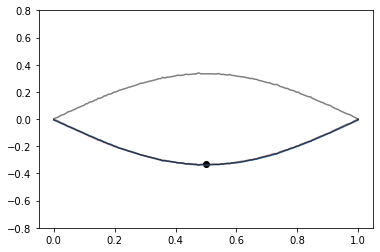

In [17]:
plt.ylim((-0.8, 0.8))

plt.plot(torch.linspace(0, 1, 200), pred_cnp[0,:,0])
plt.plot(torch.linspace(0, 1, 200), pred_wta[0,0,:,0], 'r', alpha=0.2)
plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'r', alpha=gate[0, 0, 1].item())

plt.scatter(obs[0, 0, 0], obs[0,0,1], c='k')
# plt.scatter(obs[0, 1, 0], obs[0,1,1], c='k')
plt.plot(torch.linspace(0, 1, 200), y[0], 'k', alpha=0.5)
plt.plot(torch.linspace(0, 1, 200), y[1], 'k', alpha=0.5)

In [18]:
gate

tensor([[[1.0000e+00, 3.4441e-07]]])